In [1]:
from pathlib import Path
import json
import random

from itertools import product, permutations

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IV127 = Path('/content/drive/My Drive/IV127')
english = IV127 / 'english'
filenames = list((english).iterdir())

In [4]:
filenames

[PosixPath('/content/drive/My Drive/IV127/english/umimeanglickycz-system_ps_problem.csv'),
 PosixPath('/content/drive/My Drive/IV127/english/umimeanglickycz-system_ps.csv'),
 PosixPath('/content/drive/My Drive/IV127/english/umimeanglickycz-stavba_vet_sentence2.csv'),
 PosixPath('/content/drive/My Drive/IV127/english/fillin_stats.csv')]

In [5]:
def get_object_from_string(row):
    try:
        return eval(row)['sentences']
    except SyntaxError:
        return None

system_ps_problem = english / 'umimeanglickycz-system_ps_problem.csv'
system_ps = english / 'umimeanglickycz-system_ps.csv'
stavba_vet = english / 'umimeanglickycz-stavba_vet_sentence2.csv'
stats = english / 'fillin_stats.csv'

system_ps_df = pd.read_csv(system_ps, sep=';')
system_ps_df = system_ps_df[(system_ps_df.exercise == 60) & (system_ps_df.visible == 1)]
system_ps_df = system_ps_df.loc[:, ['id', 'url']].rename(columns={"id": "ps"})
system_ps_problem_df = pd.read_csv(system_ps_problem, sep=';')
stavba_vet_df = pd.read_csv(stavba_vet, sep=';', converters={'sentence': get_object_from_string}, usecols=['id', 'sentence'])
stats_df = pd.read_csv(stats, sep=';')

In [6]:
mapping = system_ps_df.merge(system_ps_problem_df, how='inner', on='ps')
df = mapping.merge(stavba_vet_df, how='inner', left_on='problem', right_on='id').drop(['id_x', 'id_y', 'ps'],axis=1)
df['level'] = df['url'].str.extract(pat=r'-(\d)-*')
df['topic'] = df['url'].str.replace('doplnovani-slovicek-', '').str.replace('-\d-*', '').str.replace('uroven', '')
df['fullname'] = df['url'].str.replace('doplnovani-slovicek-', '')
df = df.drop('url', axis=1)

In [7]:
original_size = len(df)
df.head()

,problem,sentence,level,topic,fullname
0,42,"[{'sentence': 'Small children are very _ .', '...",2,pridavna-jmena,pridavna-jmena-2-uroven
1,43,"[{'sentence': 'Petrol is no longer a _ fuel.',...",2,pridavna-jmena,pridavna-jmena-2-uroven
2,44,"[{'sentence': 'He is a very _ swimmer.', 'tran...",2,pridavna-jmena,pridavna-jmena-2-uroven
3,45,"[{'sentence': 'He used to be a _ man.', 'trans...",2,pridavna-jmena,pridavna-jmena-2-uroven
4,46,"[{'sentence': 'Iron is more _ than gold.', 'tr...",2,pridavna-jmena,pridavna-jmena-2-uroven


In [8]:
df = df.dropna(axis=1, how='all').dropna()
cleaned_size = len(df)
print(f'Cannot process {original_size - cleaned_size} rows from {original_size} rows.')

Cannot process 3 rows from 656 rows.


In [9]:
df_exploded = df.explode('sentence')
df_exploded['solutions'] = df_exploded.apply(lambda row: row.sentence['solution'][0], axis=1)
df_exploded['sentence'] = df_exploded.apply(lambda row: row.sentence['sentence'], axis=1)
solutions = df_exploded.groupby('problem').agg(list)['solutions'].to_frame()
merged = solutions.merge(df_exploded, on='problem', left_index=True, suffixes=('_agg', None))
df = merged.copy(deep=True)

In [10]:
df.head()

,problem,solutions_agg,sentence,level,topic,fullname,solutions
18,13,"[bathroom, kitchen, garden, carpet]",The _ is at the end of the hall.,2,dum-casti-domu,dum-casti-domu-2-uroven,bathroom
18,13,"[bathroom, kitchen, garden, carpet]","Tom is in the _ , cutting up some vegetables.",2,dum-casti-domu,dum-casti-domu-2-uroven,kitchen
18,13,"[bathroom, kitchen, garden, carpet]",He grows tomatoes in the _ .,2,dum-casti-domu,dum-casti-domu-2-uroven,garden
18,13,"[bathroom, kitchen, garden, carpet]",The dog is sitting on the _ .,2,dum-casti-domu,dum-casti-domu-2-uroven,carpet
19,14,"[mirror, floor, chair, shower]",Look at yourself in the _ .,2,dum-casti-domu,dum-casti-domu-2-uroven,mirror


In [11]:
grouped = df.groupby('problem')[['problem', 'sentence', 'solutions', 'fullname']].agg({'problem': list, 'sentence': list, 'solutions': list, 'fullname': 'first'})

## Install Transformers package

In [14]:
!pip install transformers
import torch
from itertools import permutations
from transformers import AutoTokenizer, AutoModelForMaskedLM

device='cuda'

def load_model(model_name):
    model = AutoModelForMaskedLM.from_pretrained(model_name).to(device)
    model.eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer, model

def score(sentence, word):
    sentence = " ".join(sentence.split())
    w = len(tokenizer.encode(sentence.replace('_', word)))
    wout = len(tokenizer.encode(sentence))
    num_masks = w - wout + 1
    labels = sentence.replace('_', word)
    mask = sentence.replace('_', '<mask>' * num_masks)
    
    tensor_labels = torch.tensor(tokenizer.encode(labels)).unsqueeze(0).to(device)
    tensor_mask = torch.tensor(tokenizer.encode(mask)).unsqueeze(0).to(device)
    with torch.no_grad():
        loss = model(tensor_mask, labels = tensor_labels)[0]
    return loss.item()

def get_bijection(row):
    assert len(row.sentence) == len(row.solutions)
    num = len(row.solutions)
    matrix = np.zeros((num, num))
    for row_ in range(num):
        for col in range(num):
            matrix[row_][col] = score(row.sentence[row_], row.solutions[col])    
    rows = list(range(num))
    all_paths = list(permutations(range(num)))
    values = [ sum([matrix[row_, col] for row_, col in zip(rows, perm)]) for perm in all_paths]
    minimum_cols = all_paths[np.argmin(values)]
    predictions = [row.solutions[col] for col in minimum_cols]
    return predictions, values

def get_certainty(values):
    softmax = torch.nn.Softmin(dim=0)
    values = torch.from_numpy(np.array(values))
    output = softmax(values)
    return output.max().item()

## My SOTA

In [15]:
model_name = 'roberta-large'
tokenizer, model = load_model(model_name)
print("Model loaded")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-large and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


#### Bijection


In [24]:
input_fn = 'correlations3.csv'

if not (IV127/ input_fn).exists():
    df = grouped.copy(deep=True)
    df['results'] = df.progress_apply(get_bijection, axis=1)
    df['pred'] = df['results'].apply(lambda row: row[0])
    df['certainty'] = df['results'].apply(lambda row: get_certainty(row[1]))
    df = df.loc[:, df.columns != 'results'].apply(pd.Series.explode)
    df.to_csv(IV127 / input_fn, index=False)

In [25]:
df = pd.read_csv(IV127 / input_fn)
corr = df.groupby('problem').agg({'certainty': 'first', 'fullname': 'first', 'solutions': list, 'pred': list})
corr = corr.reset_index()
corr.certainty.min(), corr.certainty.max()

(0.030918470071007582, 0.9478322305327624)

In [26]:
full_stats = stats_df.merge(corr, left_on='id', right_on='problem', how='right')
full_stats.head()

,id,success_rate,answer_count,median_response_time,problem,certainty,fullname,solutions,pred
0,13.0,0.798803,2172.0,22750.0,13,0.146488,dum-casti-domu-2-uroven,"[bathroom, kitchen, garden, carpet]","[bathroom, kitchen, garden, carpet]"
1,14.0,0.916017,2179.0,16800.0,14,0.356888,dum-casti-domu-2-uroven,"[mirror, floor, chair, shower]","[mirror, floor, chair, shower]"
2,15.0,0.810488,2174.0,16750.0,15,0.135768,dum-casti-domu-2-uroven,"[pool, bedroom, pillow, lamp]","[pool, bedroom, pillow, lamp]"
3,16.0,0.874532,2136.0,23075.0,16,0.098189,dum-casti-domu-2-uroven,"[armchair, door, key, address, wall]","[armchair, door, key, address, wall]"
4,17.0,0.776636,2140.0,20850.0,17,0.363332,rodina-lide-2-uroven,"[husband, aunt, child]","[husband, aunt, child]"


In [66]:
print(full_stats['success_rate'].corr(full_stats['certainty']))

0.30468807829015593


In [67]:
topics = full_stats.groupby('fullname')[['success_rate', 'certainty']].corr().unstack().iloc[:,1]

In [68]:
topics.mean()

0.15439794221992958

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns

In [85]:
# Inspired by Martin Geletka

def visualize_topics_correlations(topic_df, level=None, sort=True):
    if sort:
        topic_df = topic_df.sort_values()
    if level:
        topic_df = topic_df.loc[[i for i in topic_df.index if str(level) in i]]
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.xlim(-1, 1)
    sns.barplot(x=topic_df.values, y=topic_df.index)
    label = f'Topics with level:{level}' if level else "Topics"
    ax.set_title('Roberta large correlations with human success rate')
    ax.set_ylabel(label)
    ax.set_xlabel("Certainty")
    ax2 = ax.twinx()
    ax2.yaxis.set_tick_params(which='both')
    plt.show()

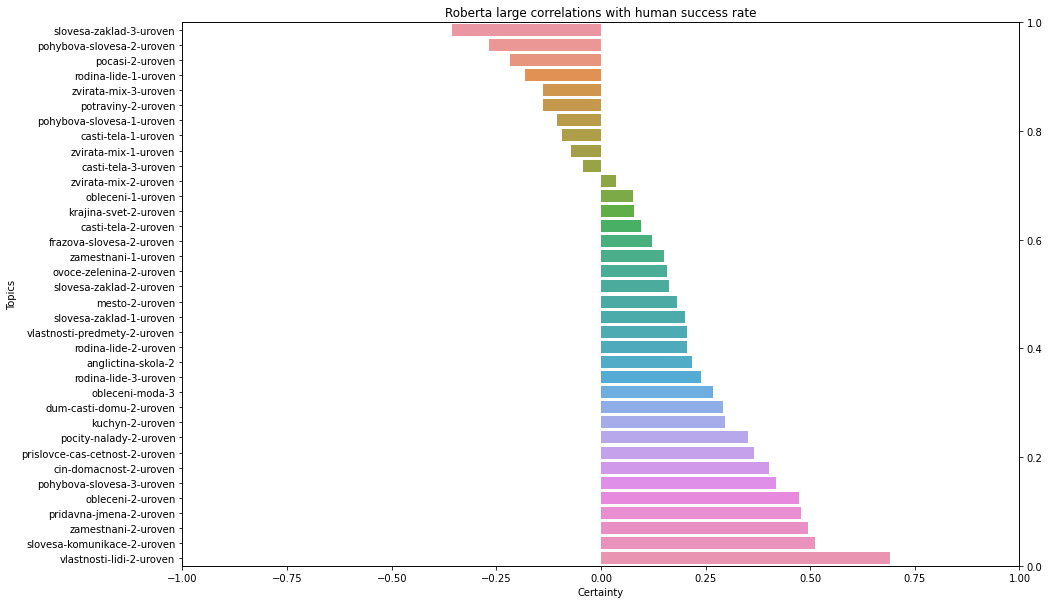

In [86]:
visualize_topics_correlations(topics)

In [90]:
full_stats[full_stats['fullname'] == 'vlastnosti-lidi-2-uroven']

,id,success_rate,answer_count,median_response_time,problem,certainty,fullname,solutions,pred
88,118.0,0.631641,847.0,27450.0,118,0.175803,vlastnosti-lidi-2-uroven,"[poor, charming, imaginative, angry]","[poor, charming, imaginative, angry]"
89,119.0,0.688839,887.0,23700.0,119,0.157271,vlastnosti-lidi-2-uroven,"[young, famous, crazy, curious]","[young, famous, crazy, curious]"
90,120.0,0.487148,817.0,34700.0,120,0.192038,vlastnosti-lidi-2-uroven,"[responsible, sad, confident, boring]","[responsible, sad, confident, boring]"
91,121.0,0.675830,873.0,26200.0,121,0.392453,vlastnosti-lidi-2-uroven,"[interesting, old, successful, careful]","[interesting, old, successful, careful]"
92,122.0,0.655592,903.0,27800.0,122,0.103911,vlastnosti-lidi-2-uroven,"[friendly, creative, horrible, amusing]","[friendly, creative, horrible, amusing]"
93,123.0,0.657679,853.0,28450.0,123,0.095015,vlastnosti-lidi-2-uroven,"[clever, dangerous, brave, humble]","[clever, dangerous, brave, humble]"
94,124.0,0.577515,845.0,34900.0,124,0.176937,vlastnosti-lidi-2-uroven,"[happy, ugly, attractive, cruel]","[happy, ugly, attractive, cruel]"
95,125.0,0.632184,870.0,27950.0,125,0.106253,vlastnosti-lidi-2-uroven,"[rich, thin, helpful, agreeable]","[rich, thin, helpful, agreeable]"
296,327.0,0.847418,852.0,16050.0,327,0.345281,vlastnosti-lidi-2-uroven,"[strong, crazy, rich]","[strong, crazy, rich]"
297,328.0,0.883450,858.0,15800.0,328,0.310475,vlastnosti-lidi-2-uroven,"[slim, stupid, famous]","[slim, stupid, famous]"


In [91]:
full_stats[full_stats['fullname'] == 'slovesa-zaklad-3-uroven']

,id,success_rate,answer_count,median_response_time,problem,certainty,fullname,solutions,pred
12,25.0,0.579545,1056.0,24825.0,25,0.241815,slovesa-zaklad-3-uroven,"[sing, thank, count, forget]","[sing, thank, count, forget]"
26,39.0,0.352595,1021.0,35750.0,39,0.167992,slovesa-zaklad-3-uroven,"[enjoy, forget, live, know, count]","[enjoy, forget, live, know, count]"
215,246.0,0.551826,1013.0,17300.0,246,0.493980,slovesa-zaklad-3-uroven,"[prepare, fail, stay]","[prepare, fail, stay]"
306,337.0,0.695219,502.0,38600.0,337,0.421433,slovesa-zaklad-3-uroven,"[drink, painting, close, enter]","[drink, painting, close, enter]"
307,338.0,0.665414,532.0,32900.0,338,0.412968,slovesa-zaklad-3-uroven,"[gather, read, saved, continue]","[gather, read, saved, continue]"
309,340.0,0.564103,507.0,34850.0,340,0.610345,slovesa-zaklad-3-uroven,"[laugh, create, meets, stay]","[laugh, create, meets, stay]"
310,341.0,0.553506,542.0,35800.0,341,0.329248,slovesa-zaklad-3-uroven,"[make, filling, reach, try]","[make, filling, reach, try]"
311,342.0,0.673114,517.0,27000.0,342,0.241335,slovesa-zaklad-3-uroven,"[shine, live, sing, lose]","[shine, live, sing, lose]"
312,343.0,0.535714,560.0,27500.0,343,0.521173,slovesa-zaklad-3-uroven,"[get, wash, enjoy, go]","[get, wash, enjoy, go]"
313,344.0,0.453184,534.0,31300.0,344,0.407334,slovesa-zaklad-3-uroven,"[rain, prepare, can, built]","[rain, prepare, can, built]"


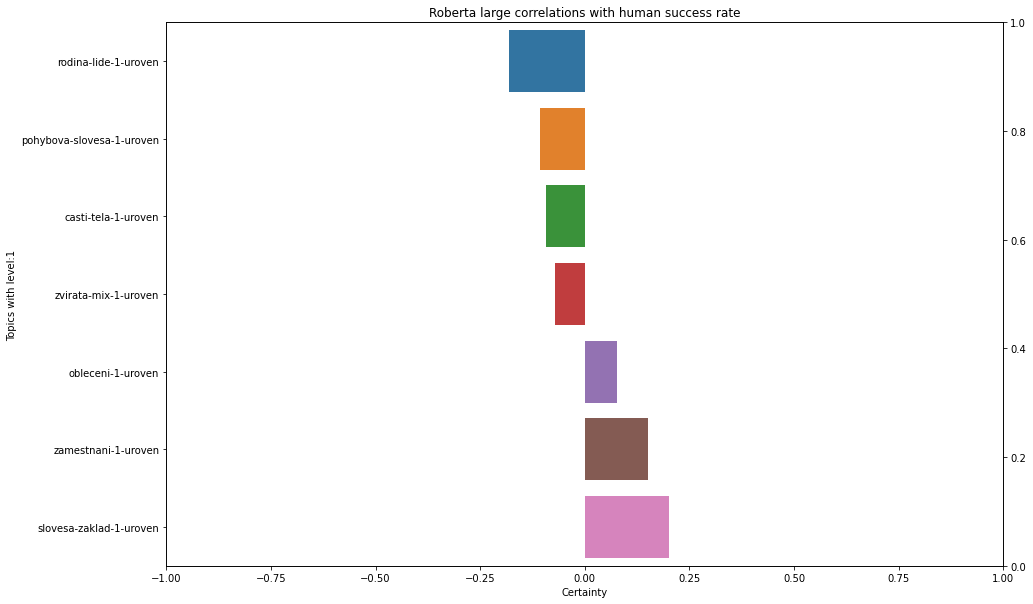

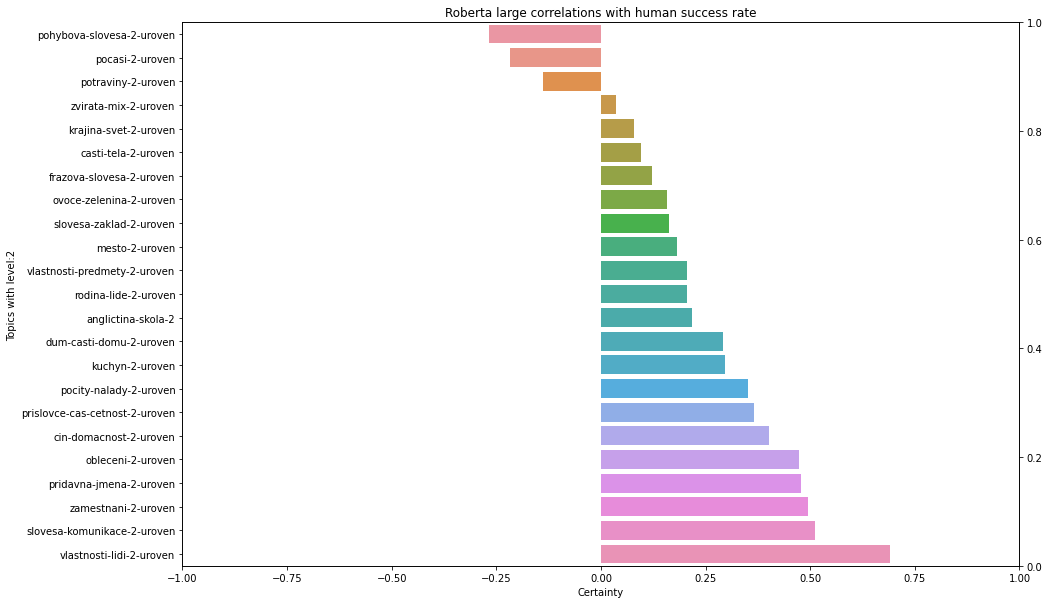

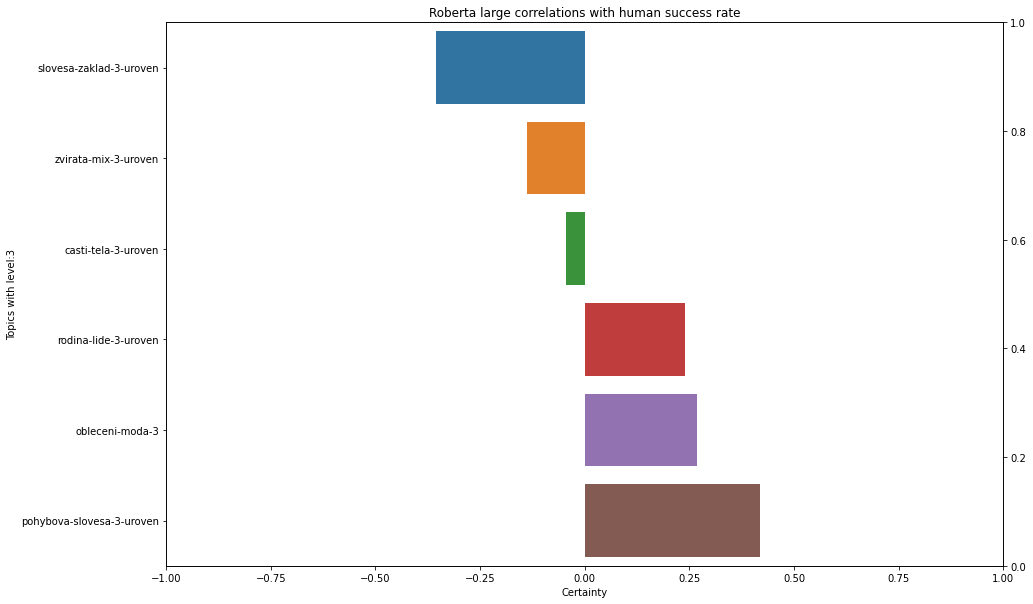

In [89]:
visualize_topics_correlations(topics, level=1)
visualize_topics_correlations(topics, level=2)
visualize_topics_correlations(topics, level=3)